In [24]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math
from component.d_scheduling.algorithm.ilp.NoTODS.NoTODS import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from dataclasses import dataclass

@dataclass
class ResultOfSchedule:
    numcircuit: int
    nameAlgorithm: str
    averageQubits: float
    nameSchedule: str
    typeMachine: dict
    
    # Metrics
    average_turnaroundTime: float
    average_responseTime: float
    average_fidelity: float
    sampling_overhead: float
    average_throughput: float
    average_utilization: float
    time_generation: float
    makespan: float
    
result_Schedule = ResultOfSchedule(
    numcircuit=0,
    nameAlgorithm="",
    averageQubits=0.0,
    nameSchedule="",
    typeMachine={},
    
    # Metrics
    average_turnaroundTime=0.0,
    average_responseTime=0.0,
    average_fidelity=0.0,
    sampling_overhead=0.0,
    average_throughput=0.0,
    average_utilization=0.0,
    time_generation=0.0,
    makespan=0.0
)

In [26]:
from component.sup_sys.algorithm_loader import load_algorithms
load_algorithms()

,Algorithm Type,Algorithm
0,ilp,MILQ_extend
1,ilp,NoTODS
2,ai,(none)
3,heuristic,FFD
4,heuristic,MTMC


In [27]:
from component.a_backend.fake_backend import *
from component.sup_sys.backend_loader import load_backends
# backendlist = load_backends()
# print(len(backendlist))
# print(backendlist)

from qiskit.visualization import plot_error_map
from component.a_backend.fake_backend import *
machines = {}
backend0 = FakeBelemV2()
backend1 = FakeManilaV2()

machines[backend0.name] = backend0
machines[backend1.name] = backend1
print(machines)
# plot_error_map(list(machines.values())[0], figsize=(10, 8))

{'fake_belem': <qiskit_ibm_runtime.fake_provider.backends.belem.fake_belem.FakeBelemV2 object at 0x71ffeac62350>, 'fake_manila': <qiskit_ibm_runtime.fake_provider.backends.manila.fake_manila.FakeManilaV2 object at 0x71ffeac63fd0>}


In [28]:
# create a dictionary of jobs with job_id as key and number of qubits as value
num_qubits_per_job = 3
num_jobs = 2
jobs = {}

for i in range(num_jobs):
    job_id = str(i + 1)
    jobs[job_id] = num_qubits_per_job

# update numcircuit
result_Schedule.numcircuit = len(jobs)
result_Schedule.averageQubits = sum(jobs.values()) / len(jobs)

In [29]:
from component.b_benchmark.mqt_tool import benchmark_circuit
from component.sup_sys.job_info import JobInfo

origin_job_info = {}

for job_name, num_qubits in jobs.items():
    circuit = benchmark_circuit(name_algorithm="ghz", circuit_size=num_qubits)
    result_Schedule.nameAlgorithm = "ghz"
    circuit.remove_final_measurements()
    origin_job_info[job_name] = JobInfo(
        job_name=job_name,
        qubits=circuit.num_qubits,
        machine=None,  # Placeholder for machine name
        capacity_machine=0,  # Placeholder for machine capacity
        start_time=0.0,  # Placeholder for start time
        duration=0.0,  # Placeholder for duration
        end_time=0.0,  # Placeholder for end time
        childrenJobs=None,  # Placeholder for child jobs
        circuit=circuit,
        result_cut=None,  # Placeholder for result cut
    )

for job in origin_job_info.values():
    job.print()

# origin_job_info['3'].circuit.draw('mpl')

process_job_info = origin_job_info.copy()

Job ID: 0002b37a-14ca-4aef-a3fc-a86d6bf08cc7
Job Name: 1
Circuit:                ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
Qubits: 3
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 0002b37a-14ca-4aef-a3fc-a86d6bf08cc7
Job Name: 2
Circuit:                ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
Qubits: 3
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None


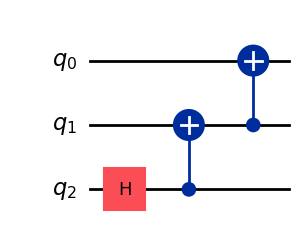

In [30]:
origin_job_info['1'].circuit.draw('mpl')

In [31]:
# Create list obj for each job
backendlist = list(machines.values())
Tau = [200]*len(backendlist)
print("Tau: ", Tau) 
print(backendlist)
obj_dict = {}
for job_name, job in process_job_info.items():
    obj_dict[job_name] = NoTODS(job.circuit, backendlist, Tau)

machine_capacity = {}
machine_capacity = {machine_name: machines[machine_name].num_qubits for machine_name in machines}
result_Schedule.typeMachine = machine_capacity
print(obj_dict)

Tau:  [200, 200]
[<qiskit_ibm_runtime.fake_provider.backends.belem.fake_belem.FakeBelemV2 object at 0x71ffeac62350>, <qiskit_ibm_runtime.fake_provider.backends.manila.fake_manila.FakeManilaV2 object at 0x71ffeac63fd0>]
{'1': <component.d_scheduling.algorithm.ilp.NoTODS.NoTODS.NoTODS object at 0x71ffeb625390>, '2': <component.d_scheduling.algorithm.ilp.NoTODS.NoTODS.NoTODS object at 0x71ffeb60d420>}


In [32]:

from component.c_circuit_work.cutting.width_c import *
subcircuit_dict = {}
sum_overhead = 0
for obj_name, obj in obj_dict.items():
    subcircuit_dict[obj_name], overhead_item  = obj_dict[obj_name]._cut_circuit()
    sum_overhead += overhead_item
    process_job_info[obj_name].childrenJobs = []
    for i, subcircuit_item in enumerate(subcircuit_dict[obj_name]['subcircuits']):
        process_job_info[obj_name].childrenJobs.append(
            JobInfo(
                job_name=f"{obj_name}_{i+1}",
                qubits=subcircuit_item.num_qubits,
                machine=None,
                capacity_machine=0,
                start_time=0.0,
                duration=0.0,
                end_time=0.0,
                childrenJobs=None,
                circuit=subcircuit_item,
                result_cut=None,
            )
        )

print(subcircuit_dict)
print()
# for job in process_job_info.values():
#     job.print()
# result_Schedule.sampling_overhead = sum_overhead

               ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
cut_name: AAB
observable: SparsePauliOp(['III'],
              coeffs=[1.+0.j])
               ┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──■──
     ┌───┐└─┬─┘     
q_2: ┤ H ├──■───────
     └───┘          
                 ┌───┐
q49_0: ──────────┤ X ├
        cut_cx_0 └─┬─┘
q49_1: ────░───────■──
           ░          
     ┌───┐ cut_cx_0 
q50: ┤ H ├────░─────
     └───┘    ░     
                 ┌───┐
q49_0: ──────────┤ X ├
        cut_cx_0 └─┬─┘
q49_1: ────░───────■──
           ░          
     ┌───┐ cut_cx_0 
q50: ┤ H ├────░─────
     └───┘    ░     
SubCircuitInfo(circuit_origin=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71ffeb70ffd0>, observable=SparsePauliOp(['III'],
              coeffs=[1.+0.j]), subcircuits={'A': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x71fff2785030>, 'B': <qisk

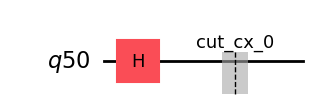

In [34]:
subcircuit_dict['1']['subcircuits'][1].draw('mpl')

In [9]:
# Get the job for run scheduler

scheduler_job = {}
def get_scheduler_jobs(job_info):
    if job_info.childrenJobs is None:
        return {job_info.job_name: job_info}
    scheduler_jobs = {}
    for child_job in job_info.childrenJobs:
        scheduler_jobs.update(get_scheduler_jobs(child_job))
    return scheduler_jobs

for job_name, job_info in process_job_info.items():
    scheduler_job.update(get_scheduler_jobs(job_info))
    
print("Scheduler Jobs:")
for job_name, job_info in scheduler_job.items():
    job_info.print()

Scheduler Jobs:
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 1_1
Circuit:     
q1: 
    
Qubits: 1
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 1_2
Circuit:     ┌───┐
q2: ┤ H ├
    └───┘
Qubits: 1
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 2_1
Circuit:     
q3: 
    
Qubits: 1
Machine: None
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 2_2
Circuit:     ┌───┐
q4: ┤ H ├
    └───┘
Qubits: 1
Machine: None
C

In [10]:
result_Schedule.nameSchedule = "NoTODS"
import time
start_time = time.time()

model = {}
for obj_name, obj in obj_dict.items():
    model[obj_name] = obj.schedule(subcircuit_dict[obj_name])
run_time = time.time() - start_time
result_Schedule.time_generation = run_time
return_model = {}
for obj_name, obj in model.items():
    for index, item in enumerate(obj, start=1):
        return_key = f"{obj_name}_{index}"
        return_model[return_key] = item
        
print(return_model)

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0,000092 after 0,00 sec. (0,00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 4 rows and 4 columns.
All rows and columns eliminated.
Presolve time = 0,00 sec. (0,00 ticks)

Root node processing (before b&c):
  Real time             =    0,00 sec. (0,00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0,00 sec. (0,00 ticks)
  Sync time (average)   =    0,00 sec.
  Wait time (average)   =    0,00 sec.
                          ------------
Total (root+branch&cut) =    0,00 sec. (0,00 ticks)
objective: 0.000
status: OPTIMAL_SOLUTION(2)
  F0_0=1
  F1_1=1
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0,000092 after 0,00 sec. (0,00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 4 rows and 4 columns.
All rows and columns eliminated.
Presolve time = 0,0

In [11]:
# update to scheduler_job
for job_name, job_info in scheduler_job.items():
    if job_name in return_model:
        job_info.machine = return_model[job_name]
        
for job_name, job_info in scheduler_job.items():
    job_info.print()
              

Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 1_1
Circuit:     
q1: 
    
Qubits: 1
Machine: fake_belem
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 1_2
Circuit:     ┌───┐
q2: ┤ H ├
    └───┘
Qubits: 1
Machine: fake_manila
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 2_1
Circuit:     
q3: 
    
Qubits: 1
Machine: fake_belem
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit: None
Transpiled Circuit Measured: None
Fidelity: None
Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 2_2
Circuit:     ┌───┐
q4: ┤ H ├
    └───┘
Qubits: 1
Machine: fak

In [12]:
machine_dict_NoTODS = {machine_name: machines[machine_name].num_qubits for machine_name in machines}
result_Schedule.typeMachine = machine_dict_NoTODS

In [13]:
import json

# Initialize machine available time
machine_times = {machine: 0.0 for machine in machine_dict_NoTODS}

# Result list
job_json = []

# Scheduling
for job_name, job_info in scheduler_job.items():
    # Select machine that is available earliest
    start_time = machine_times[job_info.machine]
    duration = job_info.qubits  # duration = number of qubits
    end_time = start_time + duration
    
    
    # Create job record
    job_record = {
        "job": job_info.job_name,
        "qubits": job_info.qubits,
        "machine": job_info.machine,
        "capacity": machine_dict_NoTODS[job_info.machine],
        "start": start_time,
        "end": end_time,
        "duration": duration
    }
    
    job_json.append(job_record)
    
    # Update machine's available time
    machine_times[job_info.machine] = end_time

# Save result to JSON file
with open('component/d_scheduling/scheduleResult/ilp/NoTODS/schedule.json', 'w') as f:
    json.dump(job_json, f, indent=4)

# # Also print nicely
# print(json.dumps(job_json, indent=4))


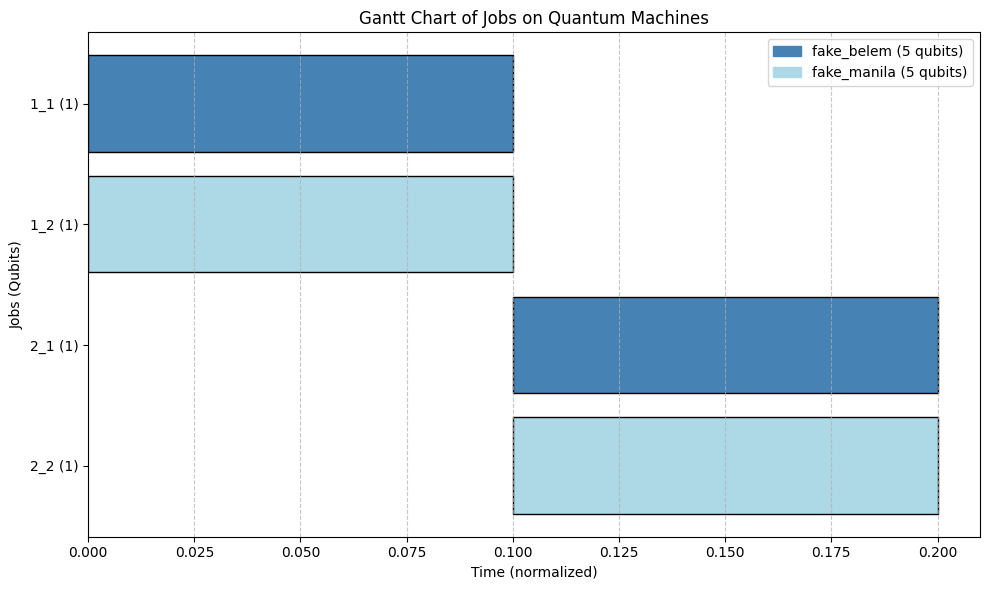

In [14]:
# Visualize data and update to dict
from component.d_scheduling.analyze import analyze_cal
from component.d_scheduling.datawork.visualize import visualize_data
from component.d_scheduling.datawork.updateToDict import update_scheduler_jobs
data = analyze_cal.load_job_data("component/d_scheduling/scheduleResult/ilp/NoTODS/schedule.json")
visualize_data(data)

In [15]:
from qiskit import QuantumCircuit, transpile
# Transpile circuits for all scheduled jobs
for job_id, job in scheduler_job.items():
    backend = machines.get(job.machine)
    if backend:
        # Perform transpilation
        job.circuit.data = [hasChange for hasChange in job.circuit.data if hasChange.operation.name != "qpd_1q"]
        job.transpiled_circuit = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
        job.circuit.measure_all()
        job.transpiled_circuit_measured = transpile(job.circuit, backend, scheduling_method='alap', layout_method='trivial')
    else:
        print(f"No backend found for machine {job.machine}. Skipping job {job_id}.")
        
    job.print()

Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 1_1
Circuit:          ░ ┌─┐
    q1: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
Qubits: 1
Machine: fake_belem
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit:                
     q1_0 -> 0 
               
ancilla_0 -> 1 
               
ancilla_1 -> 2 
               
ancilla_2 -> 3 
               
ancilla_3 -> 4 
               
Transpiled Circuit Measured:                         ░          ┌─┐
     q1_0 -> 0 ─────────░──────────┤M├
               ┌──────────────────┐└╥┘
ancilla_0 -> 1 ┤ Delay(24080[dt]) ├─╫─
               ├──────────────────┤ ║ 
ancilla_1 -> 2 ┤ Delay(24080[dt]) ├─╫─
               ├──────────────────┤ ║ 
ancilla_2 -> 3 ┤ Delay(24080[dt]) ├─╫─
               ├──────────────────┤ ║ 
ancilla_3 -> 4 ┤ Delay(24080[dt]) ├─╫─
               └──────────────────┘ ║ 
       meas: 1/═════════════════════╩═
                                 

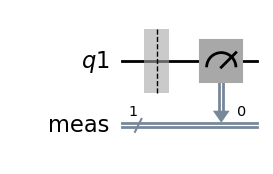

In [23]:
scheduler_job['1_1'].circuit.draw('mpl')

In [16]:
# Define the jobs
jobs = data.copy()

# Generate unique execution times
def get_the_duration_from_transpiled_circuit(circuit):
    return circuit.duration

# Simulate the scheduling with parallel execution support
def simulate_scheduling(jobs):
    machine_schedules = {'fake_belem': [], 'fake_manila': []}  # Track active jobs for each machine
    jobs = sorted(jobs, key=lambda x: x['start'])  # Sort jobs by start time
    for job in jobs:
        machine = job['machine']
        # base_duration = job['duration']
        unique_duration = get_the_duration_from_transpiled_circuit(scheduler_job[job['job']].transpiled_circuit)

        # Find the earliest time the job can start
        current_schedule = machine_schedules[machine]
        start_time = job['start']
        
        # Check for parallel execution
        while True:
            # Filter out completed jobs
            active_jobs = [j for j in current_schedule if j['end'] > start_time]
            
            # Calculate total qubits in use
            total_qubits_in_use = sum(j['qubits'] for j in active_jobs)
            if total_qubits_in_use + job['qubits'] <= job['capacity']:
                # Enough resources are available
                break
            # Increment start_time to the earliest end time of active jobs
            start_time = min(j['end'] for j in active_jobs)

        # Update job start, end times, and duration
        job['start'] = start_time
        job['end'] = start_time + unique_duration
        job['duration'] = unique_duration

        # Add job to the machine's schedule
        current_schedule.append(job)

    return jobs

# Run the simulation
updated_jobs = simulate_scheduling(jobs)

# Print the updated schedule
# for job in updated_jobs:
#     print(job)

/tmp/ipykernel_205844/1978263994.py:6: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return circuit.duration


In [17]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
import qiskit.quantum_info as qi
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from component.f_assemble.assemble_work import fidelity_from_counts

aer_simulator = AerSimulator()
for job_name, job_info in scheduler_job.items():
    backend = machines.get(job_info.machine)
    
    if backend:
        transpiled_circuit = job_info.transpiled_circuit_measured
        
        # Run the ideal simulation
        ideal_result = aer_simulator.run(transpiled_circuit, shots=1024).result()
        ideal_counts = ideal_result.get_counts(transpiled_circuit)
        
        # Run circuit on the simulated backend
        job = SamplerV2(backend).run([transpiled_circuit], shots=1024)
        sim_result = job.result()[0]
        sim_counts = sim_result.data.meas.get_counts()
        
        # Calculate fidelity
        fidelity_val, rho_ideal, rho_sim = fidelity_from_counts(ideal_counts, sim_counts)
        
        # Store the fidelity values
        job_info.fidelity = fidelity_val
        
    job_info.print()

Job ID: 61f26207-9196-427c-9b69-d33dc010e471
Job Name: 1_1
Circuit:          ░ ┌─┐
    q1: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
Qubits: 1
Machine: fake_belem
Capacity Machine: 0
Start Time: 0.0
Duration: 0.0
End Time: 0.0
Children Jobs: None
Result Cut: None
Transpiled Circuit:                
     q1_0 -> 0 
               
ancilla_0 -> 1 
               
ancilla_1 -> 2 
               
ancilla_2 -> 3 
               
ancilla_3 -> 4 
               
Transpiled Circuit Measured:                         ░          ┌─┐
     q1_0 -> 0 ─────────░──────────┤M├
               ┌──────────────────┐└╥┘
ancilla_0 -> 1 ┤ Delay(24080[dt]) ├─╫─
               ├──────────────────┤ ║ 
ancilla_1 -> 2 ┤ Delay(24080[dt]) ├─╫─
               ├──────────────────┤ ║ 
ancilla_2 -> 3 ┤ Delay(24080[dt]) ├─╫─
               ├──────────────────┤ ║ 
ancilla_3 -> 4 ┤ Delay(24080[dt]) ├─╫─
               └──────────────────┘ ║ 
       meas: 1/═════════════════════╩═
                                 

In [18]:
utilization_permachine = analyze_cal.calculate_utilization(data)
print(utilization_permachine)

defaultdict(<class 'float'>, {'fake_belem': 0.0, 'fake_manila': 0.3997501561524047})


In [19]:
# Check if have children jobs in origin_job_info
for job_name, job_info in origin_job_info.items():
    if job_info.childrenJobs is not None:
        count_fidelity = 0
        for child_job in job_info.childrenJobs:
            #updata start time and end time from child job to parent job
            job_info.start_time = min(job_info.start_time, child_job.start_time)
            job_info.end_time = max(job_info.end_time, child_job.end_time)
            job_info.duration = job_info.end_time - job_info.start_time
            count_fidelity += child_job.fidelity * child_job.qubits
        job_info.fidelity = count_fidelity / job_info.qubits
    else:
        print(f"Job {job_name} has no children jobs.")

In [21]:
print(data)

[{'job': '1_1', 'qubits': 1, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.0, 'end': 0.0, 'duration': 0}, {'job': '1_2', 'qubits': 1, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.0, 'end': 160.0, 'duration': 160}, {'job': '2_1', 'qubits': 1, 'machine': 'fake_belem', 'capacity': 5, 'start': 0.1, 'end': 0.1, 'duration': 0}, {'job': '2_2', 'qubits': 1, 'machine': 'fake_manila', 'capacity': 5, 'start': 0.1, 'end': 160.1, 'duration': 160}]


In [20]:
metrics = analyze_cal.calculate_metrics(data, utilization_permachine)
analyze_cal.print_metrics(metrics)

result_Schedule.average_turnaroundTime = metrics['average_turnaroundTime']
result_Schedule.average_responseTime = metrics['average_responseTime']
result_Schedule.makespan = metrics['makespan']
result_Schedule.average_utilization = metrics['average_utilization']
result_Schedule.average_throughput = metrics['throughput']

160.1
4
40.025


In [22]:
# Calculate all the values of components
sum_fidelity = 0
for job_name, job_info in origin_job_info.items():
    sum_fidelity += job_info.fidelity * job_info.qubits
average_fidelity = sum_fidelity / (result_Schedule.averageQubits * result_Schedule.numcircuit)
result_Schedule.average_fidelity = average_fidelity

In [23]:
import os
import json
from dataclasses import asdict

# Create the directory path
algorithm_folder_path = os.path.join("component", "finalResult", result_Schedule.nameSchedule)
os.makedirs(algorithm_folder_path, exist_ok=True)

# Construct the base file name
numcircuit = result_Schedule.numcircuit
numqubit = result_Schedule.averageQubits
base_filename = f"{numcircuit}_{numqubit}"

# Ensure the filename is unique
existing_files = os.listdir(algorithm_folder_path)
matching_files = [f for f in existing_files if f.startswith(base_filename) and f.endswith(".json")]

if not matching_files:
    final_filename = f"{base_filename}_0.json"
else:
    suffixes = [
        int(f.replace(base_filename, "").replace(".json", "").replace("_", ""))
        for f in matching_files
        if f.replace(base_filename, "").replace(".json", "").replace("_", "").isdigit()
    ]
    next_suffix = max(suffixes, default=0) + 1
    final_filename = f"{base_filename}_{next_suffix}.json"

# Define the output file path
output_file_path = os.path.join(algorithm_folder_path, final_filename)

# Save the result to the JSON file
with open(output_file_path, "w") as f:
    json.dump(asdict(result_Schedule), f, indent=4)

# Print the result
print(f"Result saved to {output_file_path}")

Result saved to component/finalResult/NoTODS/5_6.0_4.json


Plot saved to: component/finalResult/NoTODS/scheduling_metrics_plot_2.pdf


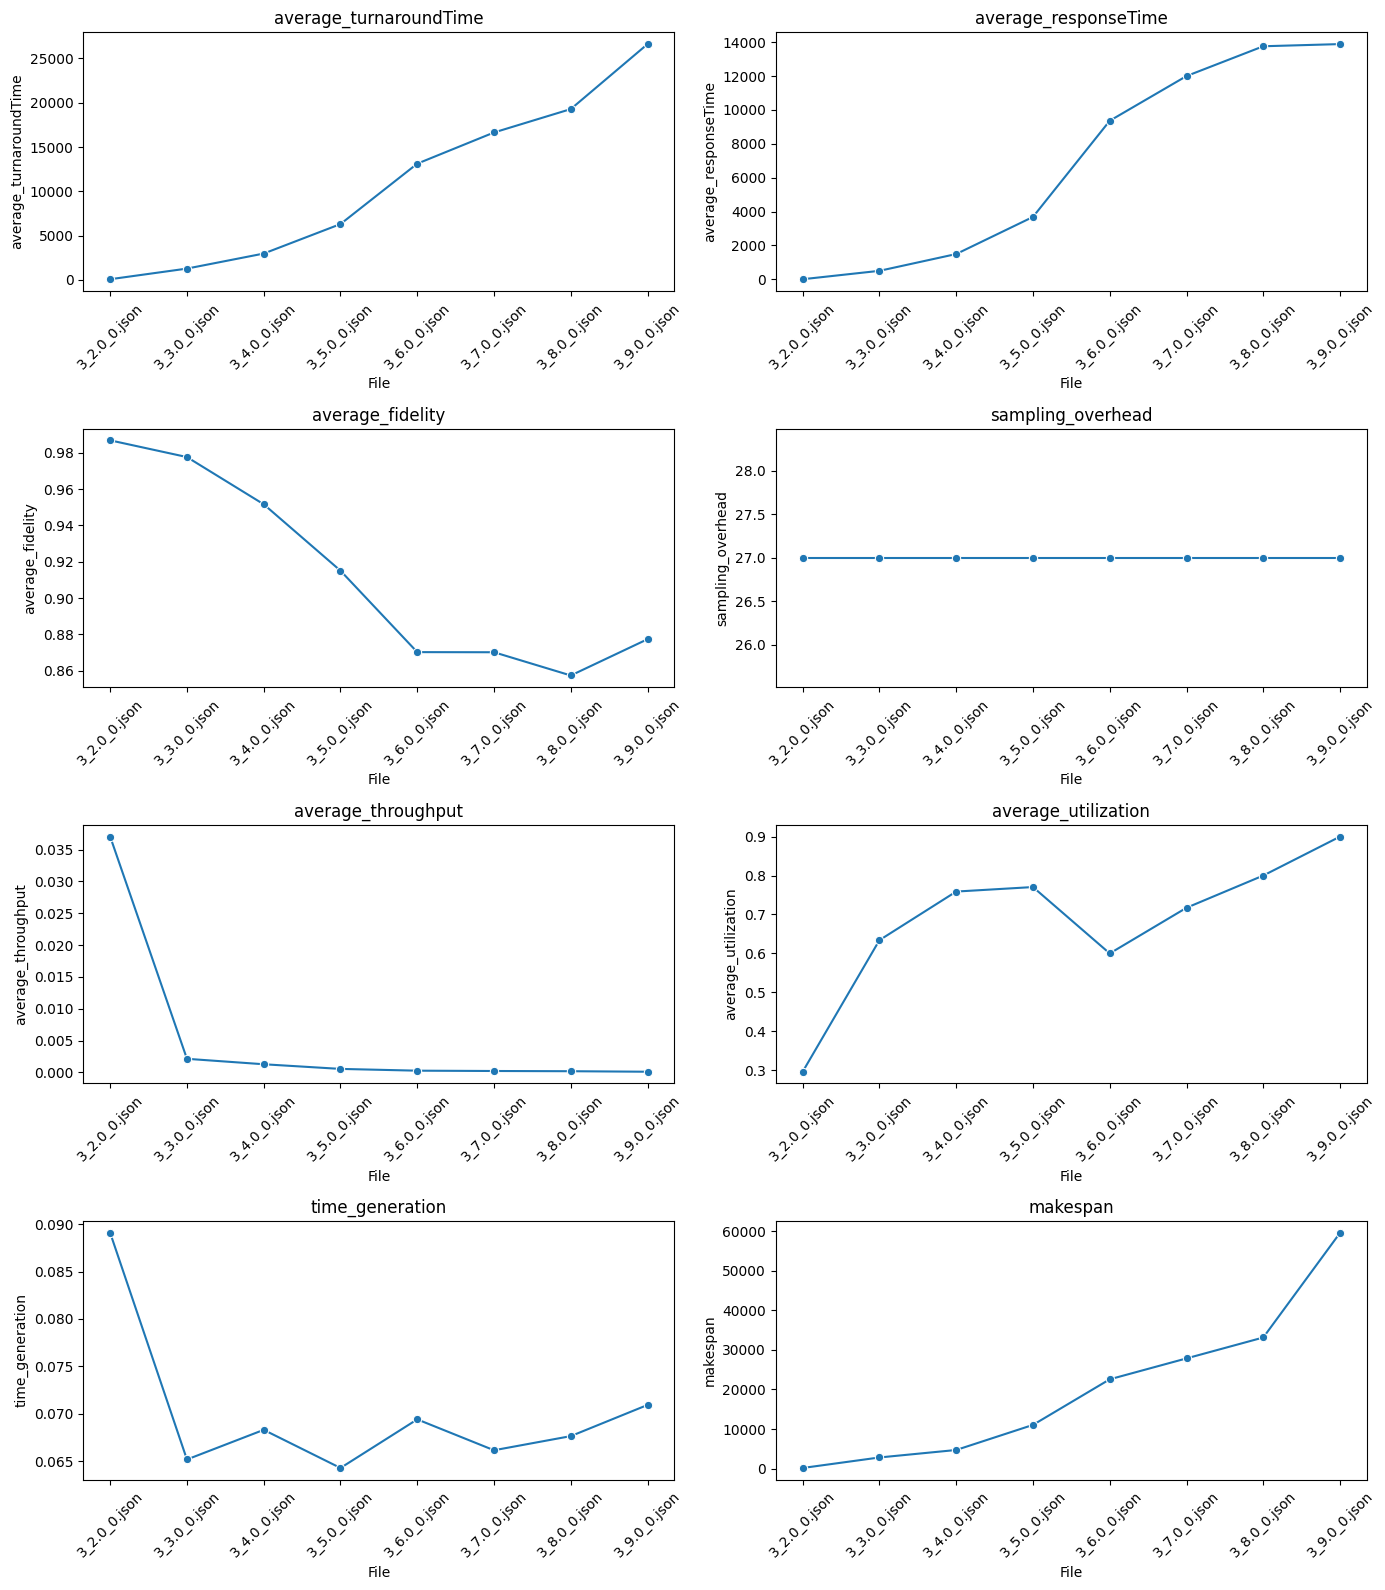

In [ ]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import math

# Define the folder where your JSON files are stored
folder_path = os.path.join("component", "finalResult", "NoTODS")

num_circuit = 3
# num_qubits = 2

# Regex pattern to match filenames like 5_2.0_0.json, 5_2.0_1.json, etc.
pattern = re.compile(rf"{num_circuit}_([10|[1-9])\.0_0\.json")

# Metrics to extract from each JSON file
metrics = [
    "average_turnaroundTime",
    "average_responseTime",
    "average_fidelity",
    "sampling_overhead",
    "average_throughput",
    "average_utilization",
    "time_generation",
    "makespan"
]

# Read data from matching JSON files
data = []
for file in os.listdir(folder_path):
    if pattern.match(file):
        with open(os.path.join(folder_path, file), "r") as f:
            content = json.load(f)
            entry = {metric: content[metric] for metric in metrics}
            entry["filename"] = file
            data.append(entry)

# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

# Sort by numeric order based on the filename
df["sort_key"] = df["filename"].str.extract(rf"{num_circuit}_(\d+)\.0_0\.json")[0].astype(int)
df = df.sort_values(by="sort_key")

# Create subplots for each metric
fig, axes = plt.subplots(math.ceil(len(metrics) / 2), 2, figsize=(14, 16))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=df, x="filename", y=metric, marker="o")
    axes[i].set_title(metric)
    axes[i].set_xlabel("File")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Adjust layout and save to PDF
plt.tight_layout()
pdf_output_path = os.path.join(folder_path, "scheduling_metrics_plot.png")

# Ensure the filename is unique if the file already exists
if os.path.exists(pdf_output_path):
    base_name, ext = os.path.splitext(pdf_output_path)
    counter = 1
    while os.path.exists(f"{base_name}_{counter}{ext}"):
        counter += 1
    pdf_output_path = f"{base_name}_{counter}{ext}"
plt.savefig(pdf_output_path)

print(f"Plot saved to: {pdf_output_path}")